# **Load The Data** 

In [ ]:
import pandas as pd
import numpy as np
# Load pickled data
import pickle
import warnings
warnings.filterwarnings('ignore')

training_file = "train.p"
validation_file="valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
#print(train)
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
# print("trainX")
# print(X_train[0:5])
# print("$$$$$$$$$$$$")
# print(y_train)
# print("$$$$$$$$$$$$")
train_sizes, train_coords = train['sizes'], train['coords']
valid_sizes, valid_coords = valid['sizes'], valid['coords']
test_sizes, test_coords = test['sizes'], test['coords']
# print("$$$$$$$$$$$$")
# print("trainsize")
# print(train_sizes)
# print("$$$$$$$$$$$$")
# print("train_coords")
# print(train_coords)
print("Done importing images.")


Done importing images.


In [ ]:
signnames = pd.read_csv('./signnames.csv')
signnames.set_index('ClassId',inplace=True)

def get_name_from_label(label):
    # Helper, transofrm a numeric label into the corresponding strring
    return signnames.loc[label].SignName

# **Dataset Summary & Exploration**

In [ ]:
# Number of training examples
n_train = X_train.shape[0]  

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

#the shape of a traffic sign image
image_shape =  X_train.shape

# numbre of classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_validation)
print("Image data shape =", X_train.shape[1:])
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


# **Data exploration visualization.**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline


In [ ]:
counter = Counter(y_train)
print("Train example per class mean {} min {} max {}".format(int(np.mean(list(Counter(y_train).values()))),
                                                    np.min(list(Counter(y_train).values())) ,
                                                    np.max(list(Counter(y_train).values())) ))
print("Most common signs:")
for el in counter.most_common(10):
    print("'{}'".format(get_name_from_label(el[0])),' train samples: {}'.format(el[1]))
print()
print("Most rare signs:")
for el in sorted(counter.items(),key=lambda x: x[1])[:10]:
    print("'{}'".format(get_name_from_label(el[0])),' train samples: {}'.format(el[1]))

Train example per class mean 911 min 210 max 2250
Most common signs:
'Speed limit (50km/h)'  train samples: 2250
'Speed limit (30km/h)'  train samples: 2220
'Yield'  train samples: 2160
'Priority road'  train samples: 2100
'Keep right'  train samples: 2070
'No passing for vehicles over 3.5 metric tons'  train samples: 2010
'Speed limit (70km/h)'  train samples: 1980
'Speed limit (80km/h)'  train samples: 1860
'Road work'  train samples: 1500
'No passing'  train samples: 1470

Most rare signs:
'Speed limit (20km/h)'  train samples: 210
'Dangerous curve to the left'  train samples: 210
'Go straight or left'  train samples: 210
'Pedestrians'  train samples: 240
'End of all speed and passing limits'  train samples: 240
'End of no passing'  train samples: 240
'End of no passing by vehicles over 3.5 metric tons'  train samples: 240
'Road narrows on the right'  train samples: 270
'Bicycles crossing'  train samples: 270
'Keep left'  train samples: 300


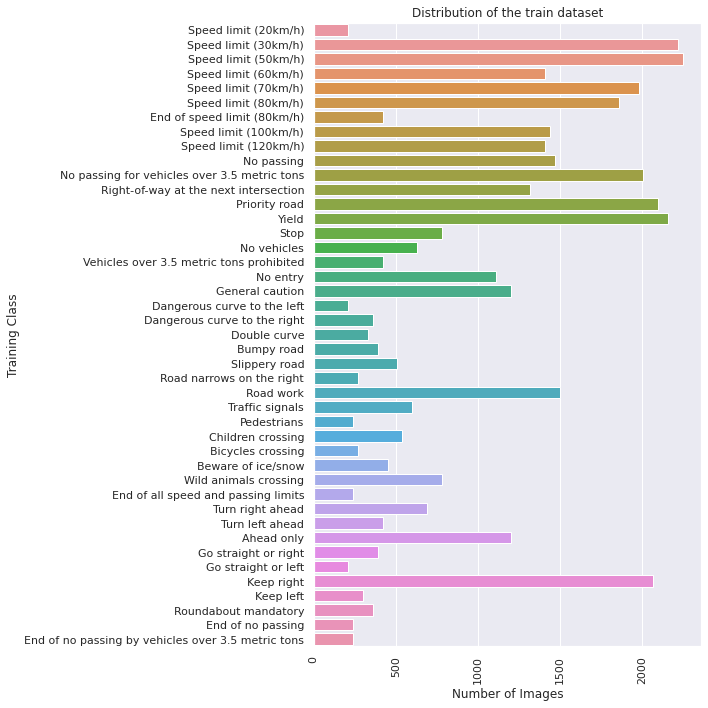

In [ ]:
# Distribution of images per class 
counts = pd.DataFrame(columns=['sign_label','training_samples_count'],data=[(label, count) for label, count in counter.items()])
counts['sign'] = counts.sign_label.apply(get_name_from_label)

plt.figure(figsize=(10,10))
sns.set(font_scale=1)
sns.barplot(data=counts,x='training_samples_count',y='sign')
plt.xticks(rotation=90)
plt.ylabel('Training Class')
plt.xlabel('Number of Images');
plt.title("Distribution of the train dataset")
plt.tight_layout()
#plt.savefig('training_set_counts.png')

#generate random image max 5 raw & clos

In [ ]:
"""

def get_random_samples(n_max):
    selected = list()
    n_raw=5
    for current_label in range(n_raw):
        found=0
        while found<n_max:
            ii = np.random.randint(len(y_train))
            
            if current_label == y_train[ii]:
                selected.append(ii)
                found+=1

    assert len(selected) ==  n_raw*n_max
    return list(selected)
    plt.figure(figsize=(12, 16))



count=0
cols = 10
for ii in get_random_samples(cols):
    count+=1
    plt.subplot(5,cols,count)
    plt.imshow(X_train[ii])
    plt.axis('off')
plt.tight_layout()
#plt.savefig('random_examples.png')

"""

"\n\ndef get_random_samples(n_max):\n    selected = list()\n    n_raw=5\n    for current_label in range(n_raw):\n        found=0\n        while found<n_max:\n            ii = np.random.randint(len(y_train))\n            \n            if current_label == y_train[ii]:\n                selected.append(ii)\n                found+=1\n\n    assert len(selected) ==  n_raw*n_max\n    return list(selected)\n    plt.figure(figsize=(12, 16))\n\ncount=0\ncols = 10\nfor ii in get_random_samples(cols):\n    count+=1\n    plt.subplot(5,cols,count)\n    plt.imshow(X_train[ii])\n    plt.axis('off')\nplt.tight_layout()\n#plt.savefig('random_examples.png')\n\n"

#**Pre-process the Data Set** 

In [ ]:
import cv2
from skimage.transform import resize
from skimage.transform import rotate
from skimage.color import rgb2gray

In [ ]:


#generate random value of image
def someRandomImageId(nb = n_train):
    return int(np.random.rand()*nb)

#normalize the data
def normalize_features_pos(img_):
    return ((img_.astype(np.float32) - 128.) / 128.)
#resize the data to (32,32)
def resizeSize(img, x=32, y=32):
    return cv2.resize(img,(x, y), interpolation = cv2.INTER_CUBIC).astype(np.uint8)

#crop roi in image
def crop(img, ROI):
    return img[(ROI[1]):(ROI[3]),(ROI[0]):(ROI[2])]

#add a new roi
def addROI(img, ROI, color=(255,0, 0)):
    copy = img.copy()
    return cv2.rectangle(copy,(ROI[0],ROI[1]),(ROI[2],ROI[3]),color)


# rectify Coords  for selecting ROI
def rectifyCoords(nb, sizes, coords):
    rectified = []
    for j in range(0, nb):
        x_ratio = image_shape[1] / sizes[j][0]
        y_ratio = image_shape[2] / sizes[j][1]
        rectified.append((int(coords[j][0]*x_ratio), int(coords[j][1]*y_ratio), \
                          int(coords[j][2]*x_ratio), int(coords[j][3]*y_ratio)))
    return rectified
    
#Augmenting function
def augment_img(img,ROI):
    #crop ROI 
    crop_ROI = crop(img, ROI)
    #Resize ROI (32,32)
    Resized_ROI=resizeSize(crop_ROI)
    #normalize ROI
    normalize_ROI=normalize_features_pos(Resized_ROI)
    #Rotate ROI by a small angle [-15°, 15°] 
    rotated_ROI = rotate(normalize_ROI,np.random.rand()*30-15)
    #GrayScal
    #GrayScal_ROI = rgb2gray(rotated_ROI)

    return rotated_ROI

#print Augmenting image
def plotAugmentation(*argv, figsize=(20, 5), save=None):
    fig = plt.figure(figsize=figsize)
    for i in range(0, len(argv[0])):    
        ax=fig.add_subplot(1,len(argv[0]),i+1)        
        ax.imshow(argv[0][i][1])
        ax.set_title(argv[0][i][0])
    if save != None:
        plt.savefig(save)
    plt.show() 


rectified_train_coords = rectifyCoords(n_train, train_sizes, train_coords)
rectified_valid_coords = rectifyCoords(n_validation, valid_sizes, valid_coords)
rectified_test_coords  = rectifyCoords(n_test,  test_sizes,  test_coords)

print("Augmenting functions defined.")



Augmenting functions defined.


# **Region of interst Cropping** &  **Normalize**
- Neural networks offer much better results when the data is normalized because it creates more variation in the data values. Practically speaking normalizing the data means that the input values range from -1 to 1 instead of being between 0 and 255 in the case of images.
- In order to add more training data and to make the network more accurate, I rotate randomly the images by a small angle [-15°, 15°] around the center of the Region Of Interest.

(32, 32)


TypeError: ignored

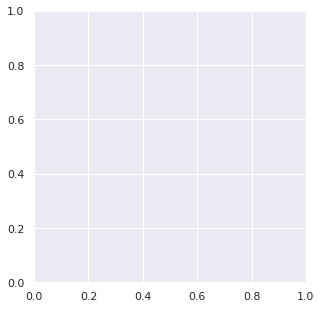

In [ ]:


#i = someRandomImageId()
#print(i)
i=10852
arguments = (('Original', X_train[i]), ('ROI', addROI(X_train[i], rectified_train_coords[i])),('normalize & Rotate ROI', augment_img(X_train[i], rectified_train_coords[i])))
print(augment_img(X_train[i], rectified_train_coords[i]).shape)
plotAugmentation(arguments)


#**Augmenting All The Dataset**

Total number of images generated per class

In [ ]:
"""

values, counts = np.unique(y_train, return_counts=True) 
max_counts = counts.max()

for class_ in values:

    print('working on class #', class_, '...')

    num_img_needed = max_counts - counts[class_]

    first_example_index = next(index for index, val in enumerate(y_train) if val==class_)
    first_example = X_train[first_example_index]

    class_ = class_.reshape([1])

    """

Running transform_images for all images

In [ ]:
"""

for num in range(0,num_img_needed):
    transformed_example = transform_image(first_example,5,5,5)
    transformed_example = transformed_example.reshape([1, 32, 32, 3])
    X_train = np.concatenate([X_train, transformed_example])
    y_train = np.concatenate([y_train, class_])


"""

Save the data for easy access

In [ ]:
"""

import os

pickle_file = 'transformed_data_2.pickle'

if not os.path.isfile(pickle_file):

    print('Saving data to pickle file...')
    try:
        with open('transformed_data_2.pickle', 'wb') as pfile:
            pickle.dump(
                {
                    'X_train': X_train,
                    'y_train': y_train,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

"""

Data cached in pickle file.


Import New generated image data

In [ ]:
"""

# Reload the data
pickle_file = 'transformed_data_2.pickle'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    X_train = pickle_data['X_train']
    y_train = pickle_data['y_train']
    #del pickle_data  # Free up memory

print('Data and modules loaded.')

"""

Data and modules loaded.


Training data splitting for validation dataset, size of Validation data is 20% of training data

In [ ]:
"""

from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)


from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

"""

In [ ]:
def pre_process_image(image):

    image_gray = np.mean(image, axis=3)
    image_gray = np.expand_dims(image_gray, axis=3)
    image_norm = (image_gray - 128)/128
    
    return image_norm

In [ ]:
X_train_processed = pre_process_image(X_train) 
X_valid_processed = pre_process_image(X_valid) 
X_test_processed = pre_process_image(X_test) 

In [ ]:


X_train_transf =[]
y_train_transf = []

# for ii in range(0,num_img_needed):
#     img = X_train[ii]
#     label = y_train[ii]
#     imgout = augment_img(img, rectified_train_coords[ii])
#     imgout.shape = (1,) + imgout.shape + (1,)
#     X_train_transf.append(imgout)
#     y_train_transf.append(label)
#     for j in range(10):
#         imgout = augment_img(img, rectified_train_coords[ii])
#         imgout.shape = (1,) + imgout.shape + (1,)
#         X_train_transf.append(imgout)
#         y_train_transf.append(label)



X_train_transf = np.concatenate(X_train_transf,axis=0)
y_train_transf = np.array(y_train_transf)



In [ ]:
X_train_processed.shape

(39209, 32, 32, 1)

In [ ]:


X_test_transf = []
X_valid_transf = []

# for ii in range(X_valid.shape[0]):
#     img = X_valid[ii]
#     img = augment_img(img, rectified_train_coords[ii])
#     img.shape = (1,) + img.shape + (1,)
#     X_valid_transf.append(img)
    
# for ii in range(X_test.shape[0]):
#     img = X_test[ii]
#     img = augment_img(img, rectified_train_coords[ii])
#     img.shape = (1,) + img.shape + (1,)
#     X_test_transf.append(img)


X_test_transf = np.concatenate(X_test_transf,axis=0)
X_valid_transf = np.concatenate(X_valid_transf,axis=0)



In [ ]:
X_valid_transf.shape

(4410, 32, 32, 1)

# **Model Architecture**

 **LeNet**


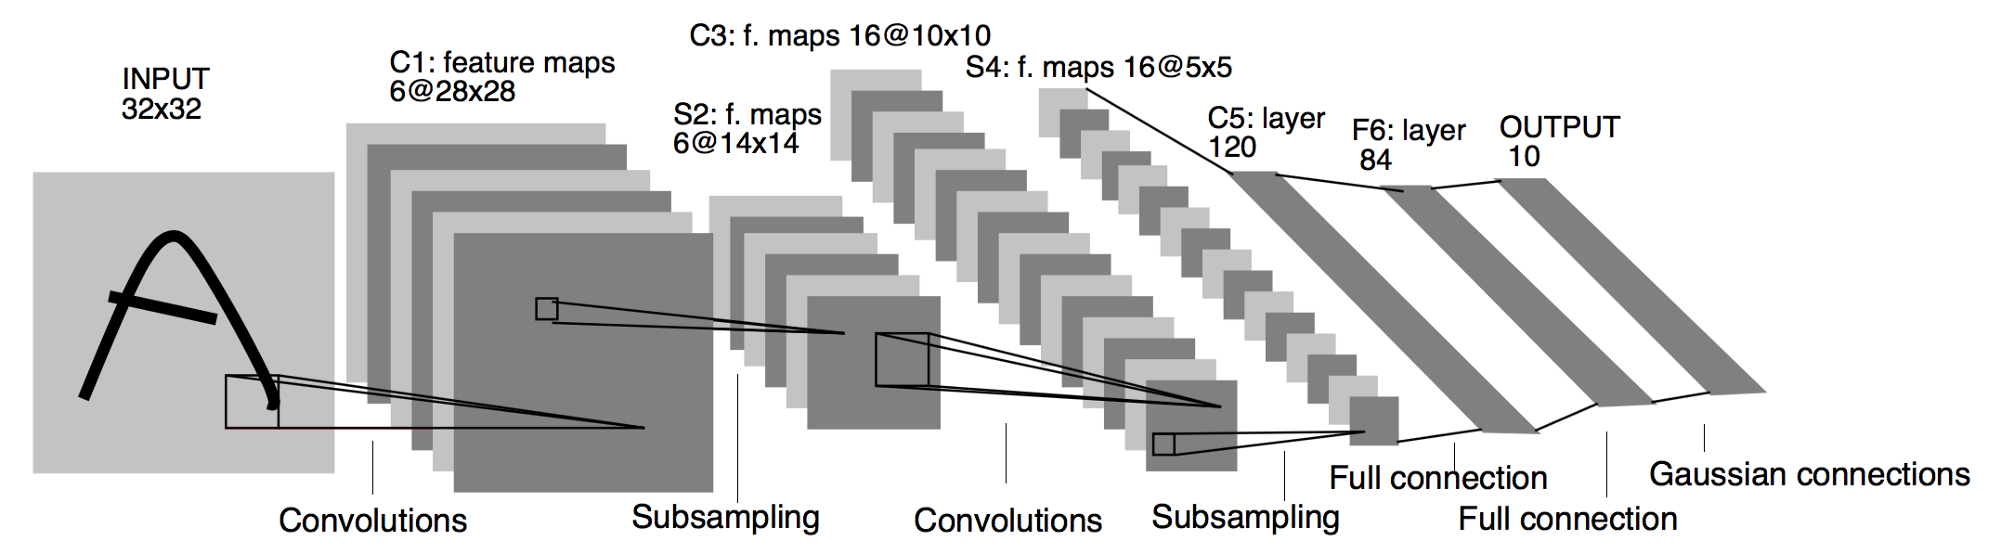

In [ ]:
!pip install --upgrade tf_slim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 352 kB 17.2 MB/s 


In [ ]:
import tensorflow as tf
import tf_slim as slim
tf.compat.v1.disable_eager_execution()

In [ ]:
#Test GPU 
#tf.test.gpu_device_name()

In [ ]:
#the number of times the algorithm sees the entire data set
EPOCHS = 70
#the number of samples (inputs) that will be passed through to the network at one time.
BATCH_SIZE = 128
#drop_out is the probability to keep the parameter -> avoid overfitting
dropout = .3

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable( tf.compat.v1.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1,name='convolution0')
    conv1 = tf.nn.dropout(conv1, keep_prob2)
    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='convolution1')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable( tf.compat.v1.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2, name='convolution2')

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='convolution3')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = slim.flatten(conv2) 
    fc0 = tf.nn.dropout(fc0, keep_prob)

    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.compat.v1.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    dr1 = tf.nn.dropout(fc1, keep_prob) 


    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable( tf.compat.v1.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    
    #Dropout_02
    fc2 = tf.nn.dropout(fc2, keep_prob)


    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.compat.v1.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma, name='weights'))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits
  
print("Model defined.")

Model defined.


# **Features and Labels**
x is a placeholder for a batch of input images. y is a placeholder for a batch of output labels. keep_prob is a placeholder for the probability to keep a unit and its connections.

In [ ]:
x = tf.compat.v1.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.compat.v1.placeholder(tf.int64, (None))
keep_prob = tf.compat.v1.placeholder(tf.float32)
keep_prob2 =tf.compat.v1.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

# **Training Pipeline**
I do not need to reduce the learning rate (***the step size at each iteration while moving toward a minimum of a loss function.)*** because the AdamOptimizer() is taking care of that. ADAM updates every parameter in the network with an individual learning rate.

Each parameter specific learning rate is computed using the learning_rate initialy given as the upper limit. This means that every single learning rate can vary from 0 (no update) to learning_rate (maximum update).

The learning rates adapt themselves during train steps. It can help to reduce loss during the latest step of training

In [ ]:
#Learning rate 
rate = 0.0001

logits = LeNet(x)
#relation between probabilities and Erreur function CE
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
predict_operation = tf.argmax(logits, 1)
predict_proba_operation = tf.nn.softmax(logits=logits)

# **Model Evaluation**
Evaluate how well the accuracy of the model for a given dataset.

In [ ]:
correct_prediction = tf.equal(predict_operation, tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.compat.v1.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0, keep_prob2:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

print("Evaluate function defined.")

Evaluate function defined.


# **Train the Model**
I feed the training data into the training pipeline to learn the weights of the model.

Before each epoch, I shuffle the training set to have a random batch of training images. This is necessary to avoid having an update of the weights biased by an over-represented class of input.

After each epoch, I measure the accuracy of the validation set.

Finally, I save the model.

In [ ]:
from sklearn.utils import shuffle
from time import time
import logging, datetime

In [ ]:
# X_train = X_train_transf
# X_valid = X_valid_transf
# X_test = X_test_transf
# y_train=y_train_transf

In [ ]:
X_train =X_train_processed 
X_valid =X_valid_processed 
X_test =X_test_processed 

In [ ]:
# """
# Log File for Metadata 
# """
# logger = logging.getLogger()
# #create file handler for logger
# def setup_file_logger(log_file):
#     hdlr = logging.FileHandler(log_file)
#     formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
#     hdlr.setFormatter(formatter)
#     logger.addHandler(hdlr) 
#     logger.setLevel(logging.INFO)

# def log(message):
#     #outputs to Colab console
#     print('{} {}'.format(datetime.datetime.now(), message))
#     #outputs to file
#     logger.info(message)

# setup_file_logger('training_Modul.log')

In [ ]:
errors = []
validation_accuracy_figure = []
training_accuracy_figure = []

saver = tf.compat.v1.train.Saver()

with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    
    print("Start Training...")
    print("Number of epochs : {}".format(EPOCHS))
    print("Batch size : {}".format(BATCH_SIZE))
    print("Learning rate : {}".format(rate))
    print("Dropout : {}".format(dropout))
    print()
    

    for i in range(EPOCHS):
        
        try:
#             reorganize the order of the list items
            X_train, y_train = shuffle(X_train, y_train)
            
            for offset in range(0, n_train, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,keep_prob:0.6, keep_prob2:0.7})
            
            print("EPOCH {} ...".format(i+1))
            # Training data
            training_accuracy = evaluate(X_train_processed, y_train)
            training_accuracy_figure.append(training_accuracy)
            # Validation data
            validation_accuracy = evaluate(X_valid_processed, y_valid)
            validation_accuracy_figure.append(validation_accuracy)
            #Erreurs 
            errors.append((training_accuracy,validation_accuracy))
            print("Training Accuracy = {:.4f}".format(training_accuracy))
            print("Training error = {:.3f} ".format( 1- training_accuracy  ))
            print("Validation Accuracy = {:.4f}".format(validation_accuracy))
            print("Validation error = {:.3f}".format( 1- validation_accuracy))
            print()
            
        except KeyboardInterrupt:
            print('Accuracy Model On Test Images: {}'.format(evaluate(X_test,y_test)))   
            break
            
    saver.save(sess, 'LeNet')
    print("Model saved")

Start Training...
Number of epochs : 150
Batch size : 128
Learning rate : 0.0001
Dropout : 0.3

EPOCH 1 ...
Training Accuracy = 0.0054
Training error = 0.995 
Validation Accuracy = 0.0068
Validation error = 0.993

Accuracy Model On Test Images: 0.004750593823933073
Model saved
